## Diffusion coefficient and alpha variation with time by running window analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns
import matplotlib.cm as cm
from scipy import stats
from hmmlearn import hmm

In [2]:
# Load the CSV file
file_path = r'Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\no_drug\Analysed Data\2x\Trackmate analysis new 07052024\csv files\window_size_5\flagged tracks\20240118_UGD-2x-2s-replicate1-FOV-2_with_cellIDs_with_step_sizes-wstepflags.csv' 
data = pd.read_csv(file_path)

In [3]:
# Ensure step_flag is boolean and filter for True values
data['step_flag'] = data['step_flag'].astype(str).str.upper() == 'TRUE'

In [4]:
track_id = 60

In [5]:
track_data = data[data['trackID'] == track_id].copy()

In [6]:
um_per_pixel = 0.117
track_data['x'] = track_data['x'] * um_per_pixel
track_data['y'] = track_data['y'] * um_per_pixel

In [7]:
s_per_frame = 2
track_data['t'] = track_data['t'] * s_per_frame

In [8]:
# Store results for future access and extract values
stored_track_data = track_data.copy()
stored_random_track_id = track_id
x = track_data['x'].values
y = track_data['y'].values
t = track_data['t'].values

# Debugging: Print x, y, t values
print("Debug information:")
print("Stored Track Data:")
print(stored_track_data)

Debug information:
Stored Track Data:
      trackID         x          y      t        R2     alpha         D  \
9717       60  5.081191  45.130172    0.0       NaN       NaN       NaN   
9718       60  5.057729  45.125352    2.0       NaN       NaN       NaN   
9719       60  5.059034  45.180306    4.0       NaN       NaN       NaN   
9720       60  5.052039  45.162486    6.0  0.104330  0.173727  0.019273   
9721       60  5.055595  45.146607    8.0  0.597256 -0.432719  0.040901   
...       ...       ...        ...    ...       ...       ...       ...   
9912       60  5.785242  46.100041  390.0  0.817390  0.249674  0.032147   
9913       60  5.811523  46.130851  392.0  0.914788  0.142411  0.023096   
9914       60  5.822279  46.110251  394.0  0.031939 -0.082622  0.025929   
9915       60  5.794643  46.124570  396.0  0.071658 -0.171664  0.029660   
9916       60  5.847941  46.098576  398.0       NaN       NaN       NaN   

         x_mean      y_mean cellID  step_sizes  mean_step_siz

x_plot: [-0.26512043 -0.28858264 -0.28727789 -0.29427279 -0.29071651 -0.25099619
 -0.24219811 -0.2517416  -0.21284729 -0.24203761 -0.23854647 -0.26845005
 -0.26424871 -0.25401745 -0.25592111 -0.2568379  -0.23802722 -0.23542354
 -0.2292929  -0.2136971  -0.2089258  -0.21924537 -0.20780769 -0.18970483
 -0.19428658 -0.18110162 -0.21741049 -0.27174534 -0.32593248 -0.42855823
 -0.50162923 -0.4514039  -0.42146496 -0.42724177 -0.39329202 -0.38947726
 -0.38290722 -0.35528994 -0.37203108 -0.30265436 -0.28368457 -0.31276637
 -0.31531376 -0.31443946 -0.3213408  -0.31374276 -0.32621844 -0.32533553
 -0.31775527 -0.33934504 -0.33161504 -0.34418176 -0.31306577 -0.32758335
 -0.34025364 -0.37476847 -0.37025978 -0.39991508 -0.39351375 -0.37134578
 -0.28792694 -0.26702592 -0.26376441 -0.26843193 -0.21526975 -0.19760003
 -0.20449195 -0.30291438 -0.19136914 -0.24960426 -0.21169237 -0.20409289
 -0.21764768 -0.2730685  -0.22402967 -0.26231875 -0.30092592 -0.26566464
 -0.25748089 -0.2575726  -0.21707436 -0.219

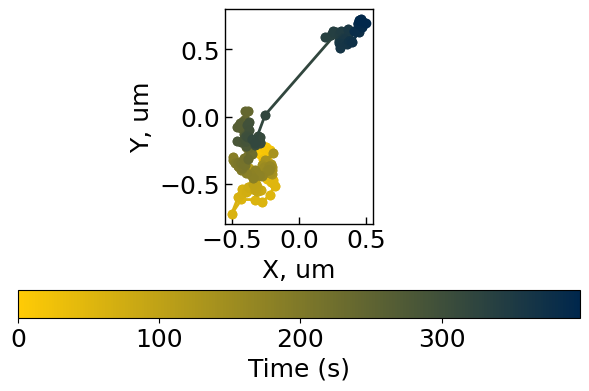

In [9]:
cmap_color_start = "#FFCB05"
cmap_color_end = "#00274C"
cmap_name = "maize2blue"
cmap = clr.LinearSegmentedColormap.from_list(cmap_name, [cmap_color_start, cmap_color_end], N=len(t))
fontsize = 18
x_plot = x - (x.min() + x.max()) / 2
y_plot = y - (y.min() + y.max()) / 2

print(f"x_plot: {x_plot}")
print(f"y_plot: {y_plot}")

fig, ax = plt.subplots(figsize=(6, 4))

# Plot the trajectory with color mapping
for i in range(len(t) - 1):
    ax.plot(
        x_plot[i:i + 2], y_plot[i:i + 2], "-o",
        color=cmap(i / len(t)),
        linewidth=2
    )

# Customize plot aesthetics
ax.axis("scaled")
ax.spines[:].set_linewidth(1)
ax.tick_params(
    axis="both",
    which="major",
    labelsize=fontsize,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1
)
ax.set_xlabel('X, um', fontsize=18)
ax.set_ylabel('Y, um', fontsize=18)

ax.relim()
ax.autoscale_view()

normalize = clr.Normalize(vmin=t.min(), vmax=t.max())
cbar = plt.colorbar(
    cm.ScalarMappable(norm=normalize, cmap=cmap),
    ax=ax,
    orientation='horizontal',
    pad=0.2,
    drawedges=False
)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('Time (s)', fontsize=18)
# Final layout adjustments and show the plot
plt.tight_layout()
plt.show()

In [10]:
# Define the MSD calculation function
def calc_MSD_NonPhysUnit(df_track, lags):
    df_track_sorted = df_track.sort_values("t")
    # Prepare storage arrays
    MSDs = []

    # Calculate MSDs corresponding to a series of lag times
    for lag in lags:
        Xs = np.array(df_track_sorted .x, dtype=float)
        Ys = np.array(df_track_sorted .y, dtype=float)

        SquareDisplacements = (Xs[lag:] - Xs[:-lag]) ** 2 + (Ys[lag:] - Ys[:-lag]) ** 2
        MSD = np.nanmean(SquareDisplacements)
        MSDs.append(MSD)

    MSDs = np.array(MSDs, dtype=float)
    return MSDs

In [11]:
# Running window analysis
window_size = 20
lags = np.linspace(1, window_size, window_size).astype(int)
lst_t_start = []
lst_log10D = []
lst_alpha = []
# Set a minimal for how many datapoints needed to calculate the last MSD value (of the largest lag)
minimal_datapoints = 5

df_track = stored_track_data.copy()  # Use stored data for window analysis

for i in range(df_track.shape[0] - lags.shape[0] - minimal_datapoints):
    MSDs = calc_MSD_NonPhysUnit(
        df_track.iloc[i: i + lags.shape[0] + minimal_datapoints], lags
    )
    if np.isnan(MSDs).any():
        print(i)
    lags_phys = lags * s_per_frame
    MSDs_phys = MSDs 
    slope_linear, intercept_linear, R_linear, P, std_err = stats.linregress(
        lags_phys, MSDs_phys
    )
    D_phys_linear = slope_linear / (8 / 3)  # um^2/s
    slope_loglog, intercept_loglog, R_loglog, P, std_err = stats.linregress(
        np.log10(lags_phys),
        np.log10(MSDs_phys),
    )
    log10D_loglog = intercept_loglog - np.log10(4)
    alpha = slope_loglog

    lst_t_start.append(df_track.iloc[i:i + lags.shape[0]]["t"].mean())
    lst_log10D.append(D_phys_linear)
    lst_alpha.append(alpha)

arr_t_start = np.array(lst_t_start, dtype=float)
arr_t_start = arr_t_start - arr_t_start[0]
arr_log10D = np.array(lst_log10D, dtype=float)
arr_alpha = np.array(lst_alpha, dtype=float)

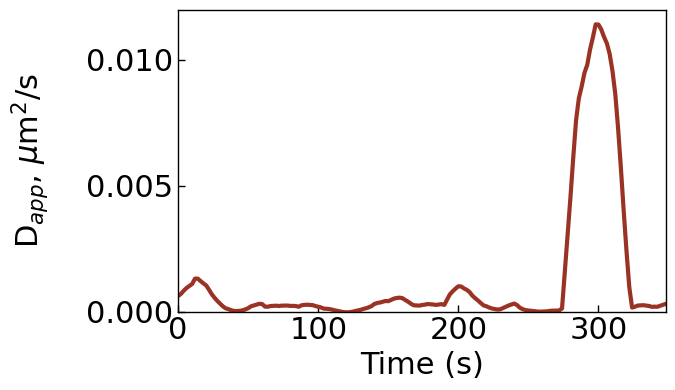

In [12]:
plt.figure(figsize=(7, 4))
plt.plot(arr_t_start, arr_log10D, lw=3, c="#9a3324")
plt.xlabel("Time (s)", fontsize=22)
plt.ylabel(r"D$_{app}$, $\mu$m$^2$/s", fontsize=22)
plt.ylim(0, None)
plt.gca().yaxis.set_label_coords(-0.26, 0.5)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(axis="both", which="major", labelsize=22, direction="in", bottom=True, left=True, length=5, width=1)
plt.xlim(arr_t_start[0], arr_t_start[-1])
plt.tight_layout()
plt.show()


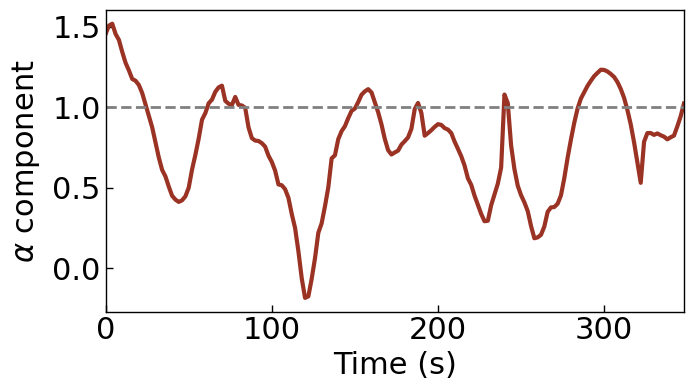

In [14]:
# Plot alpha component (normal)
plt.figure(figsize=(7, 4))
plt.plot(arr_t_start, arr_alpha, lw=3, c="#9a3324")
plt.axhline(1, ls="--", c="gray", lw=2)
plt.xlabel("Time (s)", fontsize=22)
plt.ylabel(r"$\alpha$ component", fontsize=22)
plt.gca().yaxis.set_label_coords(-0.11, 0.5)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(axis="both", which="major", labelsize=22, direction="in", bottom=True, left=True, length=5, width=1)
plt.xlim(arr_t_start[0], arr_t_start[-1])
plt.tight_layout()
plt.show()